# Lane Detection with VGG-UNET Architecture

## Download Dataset

In [ ]:
# !curl -L -o ~/Downloads/tusimple.zip\
#   https://www.kaggle.com/api/v1/datasets/download/manideep1108/tusimple

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 21.6G  100 21.6G    0     0  13.5M      0  0:27:16  0:27:16 --:--:-- 15.7MM0:21:34 15.6M  0:02:25  0:21:30 15.8M0:23:23 15.6M0:23:05 15.6M2:52 16.3M:37  0:04:19  0:22:18 16.0M  0:26:26  0:04:32  0:21:54 15.9M51  0:05:29  0:20:22 15.5M:25:36  0:05:59  0:19:37 15.7M 0  0:25:36  0:06:00  0:19:36 15.8M:16  0:07:26  0:17:50 15.1M28 15.6M04  0:17:08 15.4M  0  0:25:12  0:08:05  0:17:07 15.5M    0  0:25:06  0:09:01  0:16:05 15.8M:16:08 14.9M46 14.2M5:33 15.8M  0:15:32 13.5M:25:36  0:10:05  0:15:31 11.8M0k  0:10:27  0:15:21 13.9M:10:37  0:15:08 16.4M10:51  0:14:50 15.7M  0:11:25  0:14:18 15.3M 14.3M      0  0:25:42  0:11:32  0:14:10 14.3M.7M:25:16  0:14:34  0:10:42 12.1M5.7M    0  0:25:18  0:14:49  0:10:29 15.0M    0  0:25:17  0:14:56  0:10:21 15.3M  0:15:00

## Import Modules

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2 as cv
import random
import shutil
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

# import dl libraries
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

/opt/miniconda3/envs/nn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Dataset

In [3]:
IMAGE_FOLDER = 'tusimple_processed/images'
MASK_FOLDER = 'tusimple_processed/masks'

In [4]:
def create_if_not_exist(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created directory: {path}")
    else:
        print(f"Directory already exists: {path}")
        

In [5]:
create_if_not_exist(IMAGE_FOLDER)
create_if_not_exist(MASK_FOLDER)

Directory already exists: tusimple_processed/images
Directory already exists: tusimple_processed/masks


### Move clips to image directory

In [6]:
CLIPS_PATH = "tusimple/TUSimple/train_set/clips"

# iterate through each directory
for clip_dir in os.listdir(CLIPS_PATH):
    # Skip .DS_Store files
    if clip_dir == '.DS_Store':
        continue
        
    clip_dir_path = os.path.join(CLIPS_PATH, clip_dir)
    
    # Skip if not a directory
    if not os.path.isdir(clip_dir_path):
        continue
    
    print(f"Processing Clip: {clip_dir}")
    # iterate through each sub directory
    for frame_dir in os.listdir(clip_dir_path):
        # Skip .DS_Store files
        if frame_dir == '.DS_Store':
            continue
            
        frame_dir_path = os.path.join(clip_dir_path, frame_dir)
        
        # Skip if not a directory
        if not os.path.isdir(frame_dir_path):
            continue
            
        # Construct path to the specific image file
        image_path = os.path.join(frame_dir_path, '20.jpg')
        
        # Check if the image file exists
        if not os.path.isfile(image_path):
            continue

        temp = frame_dir_path.split('/')[-2:]  # get last 2 directory names
        new_file = f"{temp[0]}_{temp[1]}.jpg"
        new_file_path = os.path.join(IMAGE_FOLDER, new_file)

        # copy the file
        shutil.copy(image_path, new_file_path)

Processing Clip: 0601
Processing Clip: 0313-1
Processing Clip: 0531
Processing Clip: 0313-2


In [7]:
# Check how many images were processed
image_count = len([f for f in os.listdir(IMAGE_FOLDER) if f.endswith('.jpg')])
print(f"Total images processed: {image_count}")

# Show some example filenames
if image_count > 0:
    example_files = os.listdir(IMAGE_FOLDER)[:5]
    print(f"Example filenames: {example_files}")

Total images processed: 3626
Example filenames: ['0313-2_62400.jpg', '0313-2_30420.jpg', '0313-1_11800.jpg', '0313-2_34120.jpg', '0313-1_780.jpg']


In [8]:
len(os.listdir(IMAGE_FOLDER))

3626

In [9]:
df1 = pd.read_json('tusimple/TUSimple/train_set/label_data_0313.json', lines=True)
df2 = pd.read_json('tusimple/TUSimple/train_set/label_data_0531.json', lines=True)
df3 = pd.read_json('tusimple/TUSimple/train_set/label_data_0601.json', lines=True)

df = pd.concat([df1, df2, df3])
df.head()

,lanes,h_samples,raw_file
0,"[[-2, -2, -2, -2, 632, 625, 617, 609, 601, 594...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/6040/20.jpg
1,"[[-2, -2, -2, 658, 646, 635, 623, 612, 601, 58...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/5320/20.jpg
2,"[[-2, 570, 554, 538, 522, 505, 489, 473, 456, ...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/23700/20.jpg
3,"[[-2, -2, -2, -2, 555, 542, 530, 517, 505, 493...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/51660/20.jpg
4,"[[-2, -2, -2, 522, 525, 528, 531, 534, 537, 53...","[240, 250, 260, 270, 280, 290, 300, 310, 320, ...",clips/0313-1/25680/20.jpg


In [12]:
# create function for generating masks
def generate_lane_mask(row, MASK_FOLDER):
    # create a mask of all zeros
    mask = np.zeros((720, 1280, 1), dtype=np.uint8)

    # extract data from the row
    h_samples = row.h_samples
    lanes = row.lanes
    raw_file = row.raw_file

    # create mask: lane=1, non-lane=0
    for lane in lanes:
        # exclude -2 datapoints
        h_samples_filtered = [y for x, y in zip(lane, h_samples) if x != -2]
        lane_filtered = [x for x in lane if x != -2]

        # create array of lane points
        lane_points = np.array(list(zip(lane_filtered, h_samples_filtered)))

        # update lane mask
        cv.polylines(
            mask,
            [lane_points],
            isClosed=False,
            color=(255, 255, 255),
            thickness=15
        )

    # generate mask filename
    temp = raw_file[:-7].split('/')[-2:]
    mask_filename = f"{temp[0]}_{temp[1]}.jpg"
    mask_filename_path = os.path.join(MASK_FOLDER, mask_filename)

    # write the mask image
    cv.imwrite(mask_filename_path, mask)


In [13]:
for index, row in tqdm(df.iterrows(), total=len(df)):
    generate_lane_mask(row, MASK_FOLDER)

100%|██████████| 3626/3626 [00:03<00:00, 966.41it/s] 


In [14]:
print(f"Total masks generated: {len(os.listdir(MASK_FOLDER))}")

Total masks generated: 3626


In [17]:
def visualize_image(image_name):

    image_path = os.path.join(IMAGE_FOLDER, image_name)
    mask_path = os.path.join(MASK_FOLDER, image_name)

    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    mask = cv.imread(mask_path)

    plt.figure(figsize=(20,8))

    plt.subplot(1,2,1)
    plt.title("Road Image")
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Road Mask")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Ground truth mask")
    plt.imshow(mask, cmap="gray")
    plt.axis("off")

    plt.show()

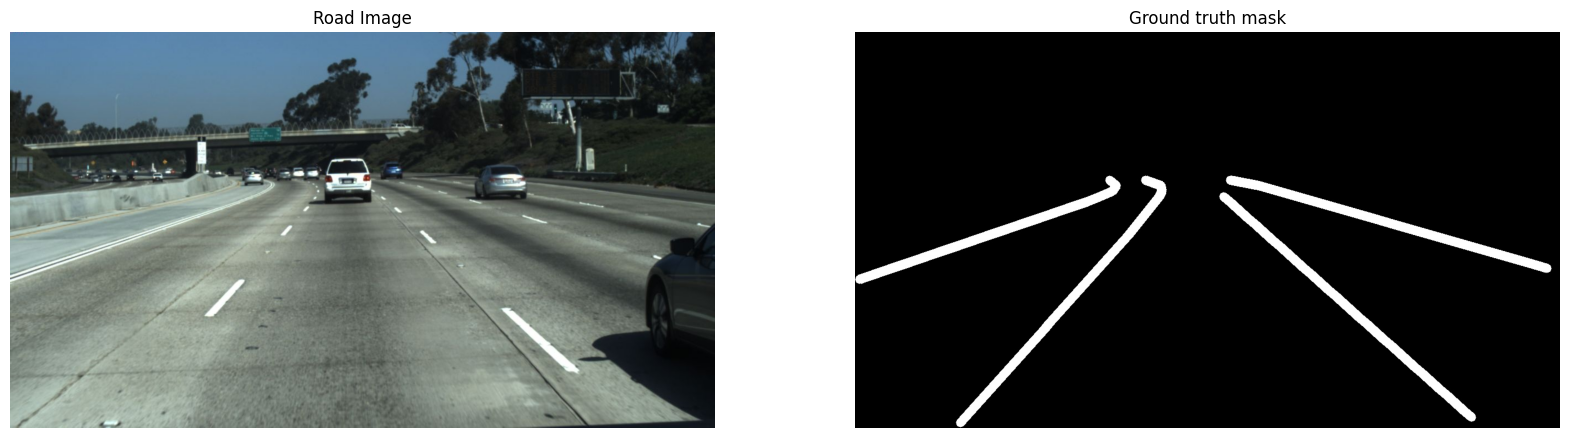

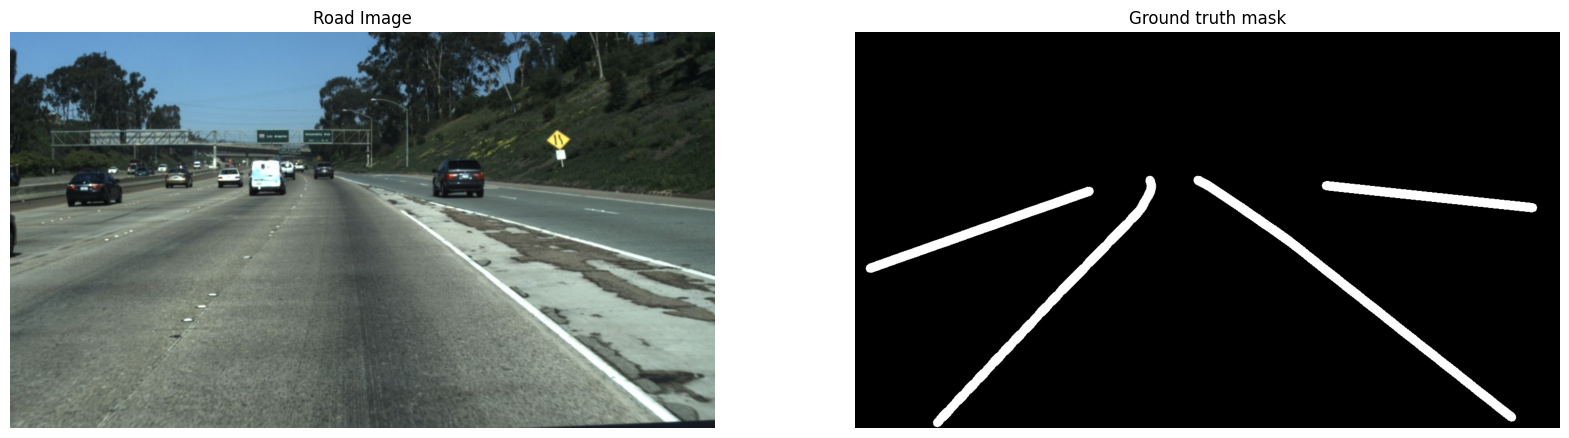

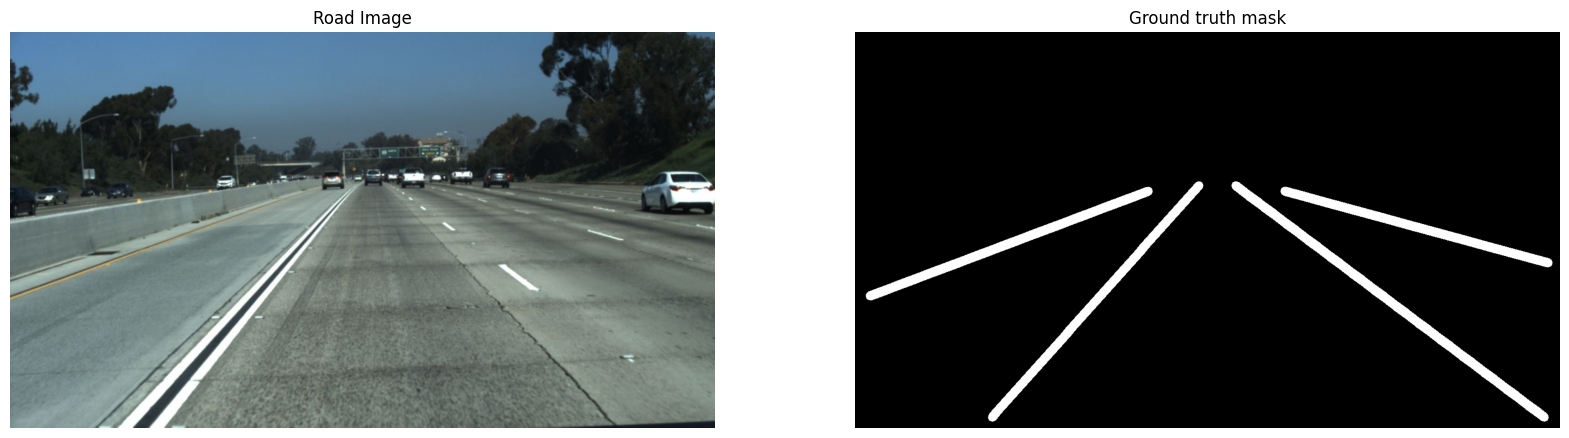

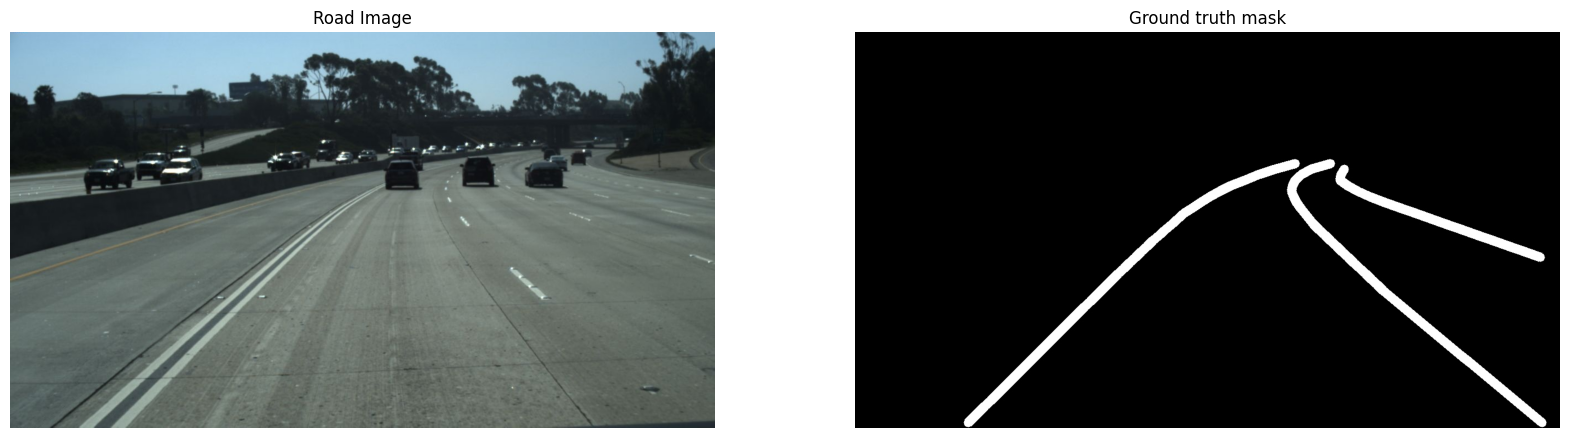

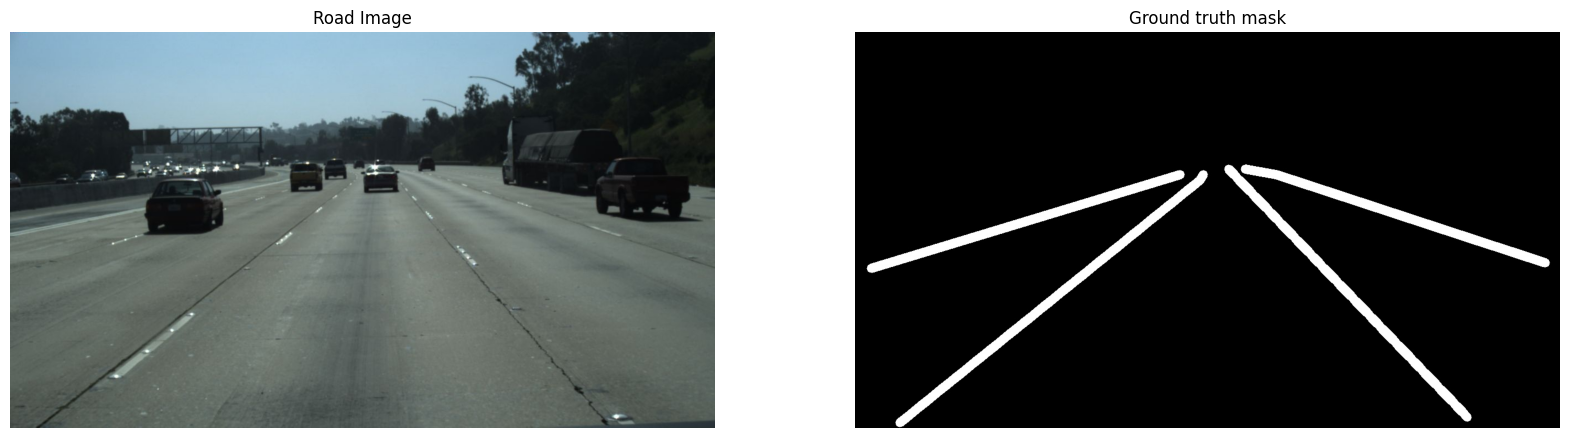

In [19]:
for _ in range(5):
    image_name = random.choice(os.listdir(IMAGE_FOLDER))
    visualize_image(image_name)

## Process data for training and testing

In [22]:
train_image_folder = 'tusimple_processed/train/images'
train_mask_folder = 'tusimple_processed/train/masks'

test_image_folder = 'tusimple_processed/test/images'
test_mask_folder = 'tusimple_processed/test/masks'

In [23]:
for path in [train_image_folder, train_mask_folder, test_image_folder, test_mask_folder]:
    create_if_not_exist(path)


Directory already exists: tusimple_processed/train/images
Directory already exists: tusimple_processed/train/masks
Directory already exists: tusimple_processed/test/images
Directory already exists: tusimple_processed/test/masks


In [25]:
from sklearn.model_selection import train_test_split

images = [file for file in os.listdir(IMAGE_FOLDER) if file.endswith('.jpg')]
masks = [file for file in os.listdir(MASK_FOLDER) if file.endswith('.jpg')]

train_image, test_image = train_test_split(images, test_size=0.2, random_state=42)


In [26]:
len(train_image), len(test_image)

(2900, 726)

In [28]:
for file in train_image:
    shutil.move(os.path.join(IMAGE_FOLDER, file), os.path.join(train_image_folder, file))
    shutil.move(os.path.join(MASK_FOLDER, file), os.path.join(train_mask_folder, file))

for file in test_image:
    shutil.move(os.path.join(IMAGE_FOLDER, file), os.path.join(test_image_folder, file))
    shutil.move(os.path.join(MASK_FOLDER, file), os.path.join(test_mask_folder, file))

In [30]:
def count_images_in_folder(folder):
    if not os.path.exists(folder):
        print(f"Folder not found: {folder}")
        return 0
    exts = ('.jpg', '.jpeg', '.png', '.bmp')
    return sum(1 for f in os.listdir(folder) if f.lower().endswith(exts))

train_imgs = count_images_in_folder(train_image_folder)
train_masks = count_images_in_folder(train_mask_folder)
test_imgs = count_images_in_folder(test_image_folder)
test_masks = count_images_in_folder(test_mask_folder)

print(f"Train images: {train_imgs}")
print(f"Train masks:  {train_masks}")
print(f"Test images:  {test_imgs}")
print(f"Test masks:   {test_masks}")

# quick sanity checks
if train_imgs != train_masks:
    print(f"Warning: train images and masks count mismatch ({train_imgs} != {train_masks})")

if test_imgs != test_masks:
    print(f"Warning: test images and masks count mismatch ({test_imgs} != {test_masks})")

Train images: 2900
Train masks:  2900
Test images:  726
Test masks:   726


### Feature Engineering

In [31]:
class ImageMaskDataset(Dataset):
    def __init__(self, image_folder, mask_folder, size=(224, 224)):
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.size = size

        # Sort to keep image-mask correspondence
        self.image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.jpg')])
        self.mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith('.jpg')])

        # Define transformations
        self.image_transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),   # Converts to [0,1]
        ])

        self.mask_transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),   # Converts to [0,1]
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        mask_path = os.path.join(self.mask_folder, self.mask_files[idx])

        image = Image.open(img_path).convert("RGB")   # 3 channels
        mask = Image.open(mask_path).convert("L")     # 1 channel

        image = self.image_transform(image)
        mask = self.mask_transform(mask)

        return image, mask


In [32]:
train_dataset = ImageMaskDataset(train_image_folder, train_mask_folder)

test_dataset = ImageMaskDataset(test_image_folder, test_mask_folder)

In [88]:

BATCH_SIZE = 32
BUFFER_SIZE = 1000  # used for shuffle in TF, not needed in PyTorch

# For training
train_loader = DataLoader(
    train_dataset,                   # your training dataset
    batch_size=BATCH_SIZE,
    shuffle=True,              # equivalent to dataset.shuffle()
    pin_memory=True,           # faster transfer to GPU
    drop_last=True             # similar to TF repeat/batch
)

# For testing/validation
test_loader = DataLoader(
    test_dataset,              # your test dataset
    batch_size=BATCH_SIZE,
    shuffle=False,             # no shuffle for test
    pin_memory=True
)


In [89]:
def display_sample(image_list):
    plt.figure(figsize=(10, 10))
    titles = ['Image', 'True Mask', 'Predicted Mask']
    to_pil = transforms.ToPILImage()  # converts tensor → PIL image for display
    
    for i in range(len(image_list)):
        plt.subplot(1, len(image_list), i + 1)
        plt.title(titles[i])
        
        # handle tensor or numpy
        img = image_list[i]
        if isinstance(img, (list, tuple)):
            img = img[0]
        
        if hasattr(img, "detach"):  # if tensor
            img = img.detach().cpu()
        
        plt.imshow(to_pil(img))
        plt.axis('off')
    
    plt.show()


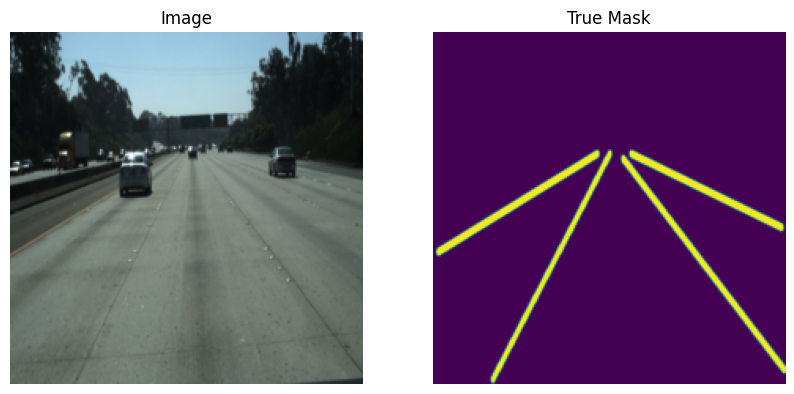

In [90]:
# get the first sample directly
image, mask = train_dataset[0]  
display_sample([image, mask])


## Model Creation - VGG-UNET

In [105]:
from torchvision.models import vgg16_bn
from torchvision.models import VGG16_BN_Weights
from torchinfo import summary

In [106]:
class Conv2DReluBatchNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, strides=1):
        super().__init__()
        padding = kernel_size // 2  # Calculate padding for 'same' effect
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, 
                              stride=strides, padding=padding)
        self.elu = nn.ELU()
        self.bn = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout2d(0.25)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.elu(x)
        x = self.conv2(x)
        x = self.elu(x)
        x = self.bn(x)
        x = self.dropout(x)
        return x

In [107]:
class VGG16_UNet(nn.Module):
    def __init__(self, input_shape=(224, 224, 3)):
        super().__init__()
        # Load pre-trained VGG16 with BatchNorm
        vgg = vgg16_bn(weights=VGG16_BN_Weights.IMAGENET1K_V1)
        
        # Extract VGG features without the final pooling and classifier
        features = list(vgg.features.children())
        
        # Encoder layers - manually separate conv blocks and pooling
        self.encoder1 = nn.Sequential(*features[:6])    # Conv block 1: 64 channels
        self.encoder2 = nn.Sequential(*features[7:13])  # Conv block 2: 128 channels  
        self.encoder3 = nn.Sequential(*features[14:23]) # Conv block 3: 256 channels
        self.encoder4 = nn.Sequential(*features[24:33]) # Conv block 4: 512 channels
        self.encoder5 = nn.Sequential(*features[34:43]) # Conv block 5: 512 channels
        
        # Decoder layers with proper upsampling
        self.up6 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.conv6 = Conv2DReluBatchNorm(512 + 512, 512)
        
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = Conv2DReluBatchNorm(256 + 256, 256)
        
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = Conv2DReluBatchNorm(128 + 128, 128)
        
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = Conv2DReluBatchNorm(64 + 64, 64)
        
        self.final_conv = nn.Conv2d(64, 1, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder with manual pooling to preserve feature maps
        e1 = self.encoder1(x)                    # 64 channels, 224x224
        e1_pool = nn.functional.max_pool2d(e1, 2, 2)  # 64 channels, 112x112
        
        e2 = self.encoder2(e1_pool)              # 128 channels, 112x112
        e2_pool = nn.functional.max_pool2d(e2, 2, 2)  # 128 channels, 56x56
        
        e3 = self.encoder3(e2_pool)              # 256 channels, 56x56
        e3_pool = nn.functional.max_pool2d(e3, 2, 2)  # 256 channels, 28x28
        
        e4 = self.encoder4(e3_pool)              # 512 channels, 28x28
        e4_pool = nn.functional.max_pool2d(e4, 2, 2)  # 512 channels, 14x14
        
        e5 = self.encoder5(e4_pool)              # 512 channels, 14x14

        # Decoder with skip connections
        d6 = self.up6(e5)                        # 512 channels, 28x28
        d6 = torch.cat([d6, e4], dim=1)          # 1024 channels, 28x28
        d6 = self.conv6(d6)                      # 512 channels, 28x28

        d7 = self.up7(d6)                        # 256 channels, 56x56
        d7 = torch.cat([d7, e3], dim=1)          # 512 channels, 56x56
        d7 = self.conv7(d7)                      # 256 channels, 56x56

        d8 = self.up8(d7)                        # 128 channels, 112x112
        d8 = torch.cat([d8, e2], dim=1)          # 256 channels, 112x112
        d8 = self.conv8(d8)                      # 128 channels, 112x112

        d9 = self.up9(d8)                        # 64 channels, 224x224
        d9 = torch.cat([d9, e1], dim=1)          # 128 channels, 224x224
        d9 = self.conv9(d9)                      # 64 channels, 224x224

        out = self.final_conv(d9)                # 1 channel, 224x224
        out = self.sigmoid(out)
        
        return out

In [108]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [109]:
# Create model instance
model = VGG16_UNet(input_shape=(224, 224, 3)).to(device)


In [110]:
import torch.nn.functional as F

def dice_coefficient(y_true, y_pred):
    """Dice coefficient metric"""
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = torch.sum(y_true_f * y_pred_f)
    smooth = 1.0
    return (2.0 * intersection + smooth) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    """Dice loss function"""
    return 1 - dice_coefficient(y_true, y_pred)

def recall_smooth(y_true, y_pred):
    """Recall metric"""
    y_pred_f = y_pred.flatten()
    y_true_f = y_true.flatten()
    intersection = torch.sum(y_true_f * y_pred_f)
    return intersection / (torch.sum(y_true_f) + 1e-7)

def precision_smooth(y_true, y_pred):
    """Precision metric"""
    y_pred_f = y_pred.flatten()
    y_true_f = y_true.flatten()
    intersection = torch.sum(y_true_f * y_pred_f)
    return intersection / (torch.sum(y_pred_f) + 1e-7)

def accuracy(y_true, y_pred):
    """Accuracy metric"""
    y_pred_f = y_pred.flatten()
    y_true_f = y_true.flatten()
    
    # Convert to binary predictions (threshold at 0.5)
    y_pred_binary = (y_pred_f > 0.5).float()
    
    # True positives
    true_positives = torch.sum(y_true_f * y_pred_binary)
    
    # True negatives
    true_negatives = torch.sum((1 - y_true_f) * (1 - y_pred_binary))
    
    # Total pixels
    total_pixels = torch.numel(y_true_f)
    
    # Calculate accuracy
    accuracy_value = (true_positives + true_negatives) / total_pixels
    
    return accuracy_value

# Example usage with a PyTorch model
class DiceLoss(nn.Module):
    """Dice loss as a PyTorch Module for easier integration with training loops"""
    def __init__(self):
        super(DiceLoss, self).__init__()
        
    def forward(self, y_pred, y_true):
        return dice_loss(y_true, y_pred)



In [111]:
# Count total and trainable parameters of the existing `model`
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable = total_params - trainable_params

def _fmt(n):
    if n >= 1e6:
        return f"{n/1e6:.2f}M"
    if n >= 1e3:
        return f"{n/1e3:.2f}K"
    return str(n)

print(f"Total parameters:       {total_params} ({_fmt(total_params)})")
print(f"Trainable parameters:   {trainable_params} ({_fmt(trainable_params)})")
print(f"Non-trainable params:   {non_trainable} ({_fmt(non_trainable)})")

Total parameters:       20294465 (20.29M)
Trainable parameters:   20294465 (20.29M)
Non-trainable params:   0 (0)


Sample index: 1404, filename: 0313-2_21900.jpg
Image shape: torch.Size([3, 224, 224]), Mask shape: torch.Size([1, 224, 224]), Pred shape: torch.Size([1, 224, 224])


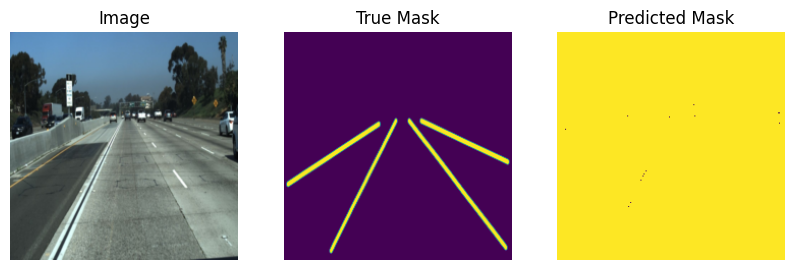

In [112]:
import torch

# Pick a random single sample from the training dataset, run through the model and visualize + print metrics.

# select random index
idx = random.randrange(len(train_dataset))
image, mask = train_dataset[idx]         # image: (3,H,W), mask: (1,H,W)
fname = train_dataset.image_files[idx]

# prepare input batch and run model
model.eval()
with torch.no_grad():
    inp = image.unsqueeze(0).to(device)      # (1,3,H,W)
    pred = model(inp)                        # (1,1,H,W)
    pred_prob = pred.detach().cpu()
    pred_bin = (pred_prob > 0.5).float()     # thresholded prediction

# squeeze batch dim for display/metrics: keep channel dim (1,H,W)
pred_prob_s = pred_prob.squeeze(0)           # (1,H,W)
pred_bin_s = pred_bin.squeeze(0)             # (1,H,W)

# Print info and metrics
print(f"Sample index: {idx}, filename: {fname}")
print(f"Image shape: {image.shape}, Mask shape: {mask.shape}, Pred shape: {pred_prob_s.shape}")

# visualize image, true mask and predicted mask
display_sample([image, mask, pred_bin_s])

In [119]:
len(train_loader), len(test_loader)

(90, 23)

In [120]:
def train_loop(model, train_loader, optimizer, loss, device, epoch=None):
    model.train()
    train_loss = 0
    
    # Create progress bar for batches
    progress_bar = tqdm(enumerate(train_loader), 
                       total=len(train_loader),
                       desc=f"Epoch {epoch+1}" if epoch is not None else "Training",
                       leave=False)

    for batch_idx, (images, masks) in progress_bar:
        images, masks = images.to(device), masks.to(device)

        # forward pass
        outputs = model(images)

        # calculate loss
        loss_value = loss(outputs, masks)
        train_loss += loss_value.item()

        # zero grad
        optimizer.zero_grad()
        
        # backward pass
        loss_value.backward()

        # optimizer step
        optimizer.step()
        
        # Update progress bar with current loss
        current_avg_loss = train_loss / (batch_idx + 1)
        progress_bar.set_postfix({
            'batch_loss': f'{loss_value.item():.4f}',
            'avg_loss': f'{current_avg_loss:.4f}'
        })

    train_loss /= len(train_loader)
    return train_loss

In [121]:
def test_loop(model, test_loader, loss, device, epoch=None):
    model.eval()
    test_loss = 0
    
    # Create progress bar for validation batches
    progress_bar = tqdm(enumerate(test_loader), 
                       total=len(test_loader),
                       desc=f"Validation Epoch {epoch+1}" if epoch is not None else "Validation",
                       leave=False)

    with torch.inference_mode():
        for batch_idx, (images, masks) in progress_bar:
            images, masks = images.to(device), masks.to(device)

            # forward pass
            outputs = model(images)

            # calculate loss
            loss_value = loss(outputs, masks)
            test_loss += loss_value.item()
            
            # Update progress bar with current loss
            current_avg_loss = test_loss / (batch_idx + 1)
            progress_bar.set_postfix({
                'batch_loss': f'{loss_value.item():.4f}',
                'avg_loss': f'{current_avg_loss:.4f}'
            })

    test_loss /= len(test_loader)
    return test_loss

In [122]:
def train(model, train_loader, test_loader, optimizer, loss, device, epochs):
    results = {"train_loss": [], "test_loss": []}
    
    print(f"Starting training for {epochs} epochs...")
    print("=" * 50)

    for epoch in tqdm(range(epochs), desc="Overall Progress"):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 30)
        
        # Training phase
        train_loss = train_loop(model, train_loader, optimizer, loss, device, epoch)
        
        # Validation phase
        test_loss = test_loop(model, test_loader, loss, device, epoch)

        # Print epoch summary
        print(f"Epoch {epoch+1} Summary:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Test Loss:  {test_loss:.4f}")
        
        # Convert to Python float if it's a tensor
        train_loss_val = train_loss.item() if hasattr(train_loss, 'item') else train_loss
        test_loss_val = test_loss.item() if hasattr(test_loss, 'item') else test_loss
        
        results["train_loss"].append(train_loss_val)
        results["test_loss"].append(test_loss_val)

    print("\n" + "=" * 50)
    print("Training completed!")
    return results

In [ ]:
# !pip install optuna optuna-dashboard

  Using cached tomli-2.2.1-py3-none-any.whl.metadata (10 kB)
  Using cached tomli-2.2.1-py3-none-any.whl.metadata (10 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/8.4 MB ? eta -:--:--Downloading optuna_dashboard-0.19.0-py3-none-any.whl (8.4 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 8.9 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/2.1 MB ? eta -:--:--Downloading sqlalchemy-2.0.43-cp310-cp310-macosx_11_0_arm64.whl (2.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.5 MB/s eta 0:00:00
Using cached tomli-2.2.1-py3-none-any.whl (14 kB)
Using cached tomli-2.2.1-py3-none-any.whl (14 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [optuna-dashboard][optuna]emy]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [optuna-dashboard]


In [125]:
import optuna
from optuna.trial import TrialState
import json
from datetime import datetime

# Lightweight VGG-UNet for Mac NPU optimization
class LightVGG16_UNet(nn.Module):
    def __init__(self, input_shape=(224, 224, 3), base_channels=32):
        super().__init__()
        # Use a lightweight version with fewer channels
        
        # Simplified encoder (reduce channels by factor of 2)
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, base_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, base_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.encoder2 = nn.Sequential(
            nn.Conv2d(base_channels, base_channels*2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*2, base_channels*2, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.encoder3 = nn.Sequential(
            nn.Conv2d(base_channels*2, base_channels*4, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*4, base_channels*4, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.encoder4 = nn.Sequential(
            nn.Conv2d(base_channels*4, base_channels*8, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*8, base_channels*8, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(base_channels*8, base_channels*16, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*16, base_channels*16, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        # Decoder
        self.up4 = nn.ConvTranspose2d(base_channels*16, base_channels*8, 2, stride=2)
        self.decoder4 = nn.Sequential(
            nn.Conv2d(base_channels*16, base_channels*8, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*8, base_channels*8, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.up3 = nn.ConvTranspose2d(base_channels*8, base_channels*4, 2, stride=2)
        self.decoder3 = nn.Sequential(
            nn.Conv2d(base_channels*8, base_channels*4, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*4, base_channels*4, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.up2 = nn.ConvTranspose2d(base_channels*4, base_channels*2, 2, stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(base_channels*4, base_channels*2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels*2, base_channels*2, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.up1 = nn.ConvTranspose2d(base_channels*2, base_channels, 2, stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(base_channels*2, base_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, base_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.final_conv = nn.Conv2d(base_channels, 1, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Encoder
        e1 = self.encoder1(x)  # 32, 224x224
        p1 = nn.functional.max_pool2d(e1, 2, 2)  # 32, 112x112
        
        e2 = self.encoder2(p1)  # 64, 112x112
        p2 = nn.functional.max_pool2d(e2, 2, 2)  # 64, 56x56
        
        e3 = self.encoder3(p2)  # 128, 56x56
        p3 = nn.functional.max_pool2d(e3, 2, 2)  # 128, 28x28
        
        e4 = self.encoder4(p3)  # 256, 28x28
        p4 = nn.functional.max_pool2d(e4, 2, 2)  # 256, 14x14
        
        # Bottleneck
        bottleneck = self.bottleneck(p4)  # 512, 14x14
        
        # Decoder with skip connections
        d4 = self.up4(bottleneck)  # 256, 28x28
        d4 = torch.cat([d4, e4], dim=1)  # 512, 28x28
        d4 = self.decoder4(d4)  # 256, 28x28
        
        d3 = self.up3(d4)  # 128, 56x56
        d3 = torch.cat([d3, e3], dim=1)  # 256, 56x56
        d3 = self.decoder3(d3)  # 128, 56x56
        
        d2 = self.up2(d3)  # 64, 112x112
        d2 = torch.cat([d2, e2], dim=1)  # 128, 112x112
        d2 = self.decoder2(d2)  # 64, 112x112
        
        d1 = self.up1(d2)  # 32, 224x224
        d1 = torch.cat([d1, e1], dim=1)  # 64, 224x224
        d1 = self.decoder1(d1)  # 32, 224x224
        
        out = self.final_conv(d1)  # 1, 224x224
        out = self.sigmoid(out)
        
        return out

In [129]:
# Set random seeds
torch.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate model with fixed architecture
model_0 = LightVGG16_UNet(input_shape=(224, 224, 3), base_channels=16).to(device)

# Setup loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Test the model with a sample to ensure shapes match
with torch.no_grad():
    sample_image, sample_mask = train_dataset[0]
    sample_input = sample_image.unsqueeze(0).to(device)
    sample_output = model_0(sample_input)
    print(f"Input shape: {sample_input.shape}")
    print(f"Output shape: {sample_output.shape}")
    print(f"Target shape: {sample_mask.unsqueeze(0).shape}")

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_loader=train_loader,
                        test_loader=test_loader,
                        optimizer=optimizer,
                        loss=loss_fn,
                        device=device, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

Input shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 1, 224, 224])
Target shape: torch.Size([1, 1, 224, 224])
Starting training for 5 epochs...


Overall Progress:   0%|          | 0/5 [00:00<?, ?it/s]


Epoch 1/5
------------------------------


Overall Progress:  20%|██        | 1/5 [00:52<03:30, 52.52s/it]

Epoch 1 Summary:
  Train Loss: 0.0554
  Test Loss:  0.0380

Epoch 2/5
------------------------------


Overall Progress:  40%|████      | 2/5 [01:44<02:36, 52.10s/it]

Epoch 2 Summary:
  Train Loss: 0.0378
  Test Loss:  0.0380

Epoch 3/5
------------------------------


Overall Progress:  60%|██████    | 3/5 [02:39<01:47, 53.51s/it]

Epoch 3 Summary:
  Train Loss: 0.0378
  Test Loss:  0.0380

Epoch 4/5
------------------------------


Overall Progress:  80%|████████  | 4/5 [03:38<00:55, 55.72s/it]

Epoch 4 Summary:
  Train Loss: 0.0378
  Test Loss:  0.0380

Epoch 5/5
------------------------------


Overall Progress: 100%|██████████| 5/5 [04:34<00:00, 54.81s/it]

Epoch 5 Summary:
  Train Loss: 0.0378
  Test Loss:  0.0380

Training completed!
Total training time: 274.056 seconds


Random sample index: 672
Filename: 0601_1494453405645043795.jpg
Image shape: torch.Size([3, 224, 224])
True mask shape: torch.Size([1, 224, 224])
Predicted mask shape: torch.Size([1, 224, 224])


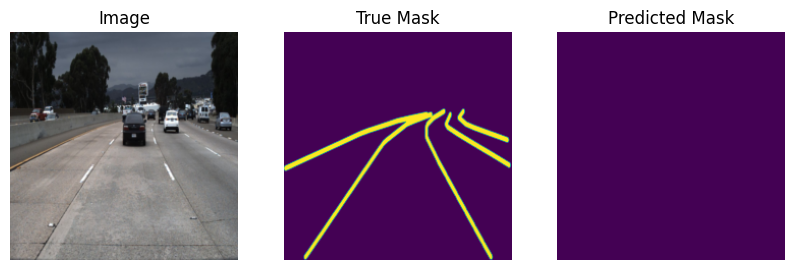

In [133]:
import random

# Display model prediction with random image from test dataset

# Select a random image from test dataset
random_idx = random.randint(0, len(test_dataset) - 1)
image, true_mask = test_dataset[random_idx]
filename = test_dataset.image_files[random_idx]

# Generate prediction
model_0.eval()
with torch.no_grad():
    input_batch = image.unsqueeze(0).to(device)
    prediction = model_0(input_batch)
    pred_mask = (prediction).float().squeeze(0).cpu()

print(f"Random sample index: {random_idx}")
print(f"Filename: {filename}")
print(f"Image shape: {image.shape}")
print(f"True mask shape: {true_mask.shape}")
print(f"Predicted mask shape: {pred_mask.shape}")

# Display the three images side by side
display_sample([image, true_mask, pred_mask])

Debugging prediction values:
Prediction tensor stats:
  Min value: 0.000000
  Max value: 0.000000
  Mean value: 0.000000
  Standard deviation: 0.000000

True mask stats:
  Min value: 0.000000
  Max value: 1.000000
  Mean value: 0.056535

Binary prediction (threshold=0.5):
  Pixels above threshold: 0.0
  Total pixels: 50176
  Percentage above threshold: 0.00%

Pixels above different thresholds:
  > 0.1: 0 pixels (0.00%)
  > 0.3: 0 pixels (0.00%)
  > 0.5: 0 pixels (0.00%)
  > 0.7: 0 pixels (0.00%)
  > 0.9: 0 pixels (0.00%)

Model training status: Evaluation


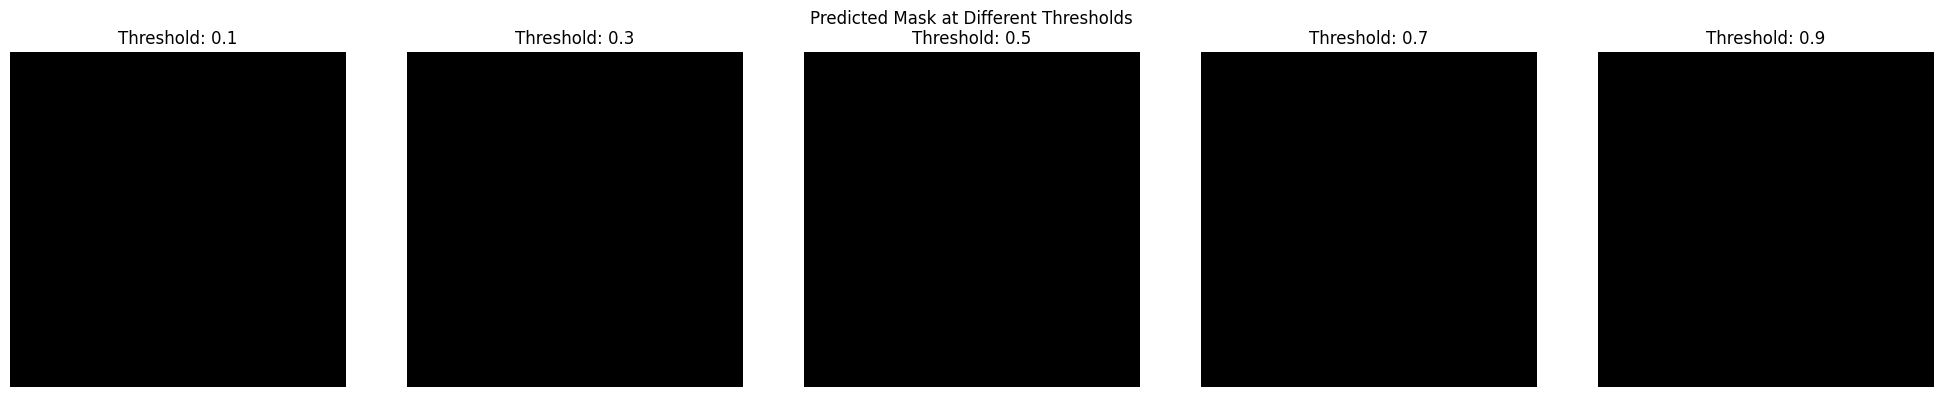

In [135]:
# Debug the prediction values
print("Debugging prediction values:")
print(f"Prediction tensor stats:")
print(f"  Min value: {prediction.min().item():.6f}")
print(f"  Max value: {prediction.max().item():.6f}")
print(f"  Mean value: {prediction.mean().item():.6f}")
print(f"  Standard deviation: {prediction.std().item():.6f}")

print(f"\nTrue mask stats:")
print(f"  Min value: {true_mask.min().item():.6f}")
print(f"  Max value: {true_mask.max().item():.6f}")
print(f"  Mean value: {true_mask.mean().item():.6f}")

# Check how many pixels are above threshold
threshold = 0.5
pred_binary = (prediction > threshold).float()
print(f"\nBinary prediction (threshold={threshold}):")
print(f"  Pixels above threshold: {pred_binary.sum().item()}")
print(f"  Total pixels: {pred_binary.numel()}")
print(f"  Percentage above threshold: {pred_binary.mean().item()*100:.2f}%")

# Try different thresholds
thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
print(f"\nPixels above different thresholds:")
for thresh in thresholds:
    above_thresh = (prediction > thresh).sum().item()
    percentage = above_thresh / prediction.numel() * 100
    print(f"  > {thresh}: {above_thresh} pixels ({percentage:.2f}%)")

# Check if the model is actually trained
print(f"\nModel training status: {'Training' if model_0.training else 'Evaluation'}")

# Display prediction with different thresholds
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
to_pil = transforms.ToPILImage()

for i, thresh in enumerate([0.1, 0.3, 0.5, 0.7, 0.9]):
    pred_thresh = (prediction > thresh).float().squeeze(0).cpu()
    axes[i].imshow(to_pil(pred_thresh), cmap='gray')
    axes[i].set_title(f'Threshold: {thresh}')
    axes[i].axis('off')

plt.suptitle('Predicted Mask at Different Thresholds')
plt.tight_layout()
plt.show()

Model weight analysis:

Overall: 0/1941105 weights are zero (0.00%)

Training results:
  Final train loss: 0.037816
  Final test loss: 0.038003


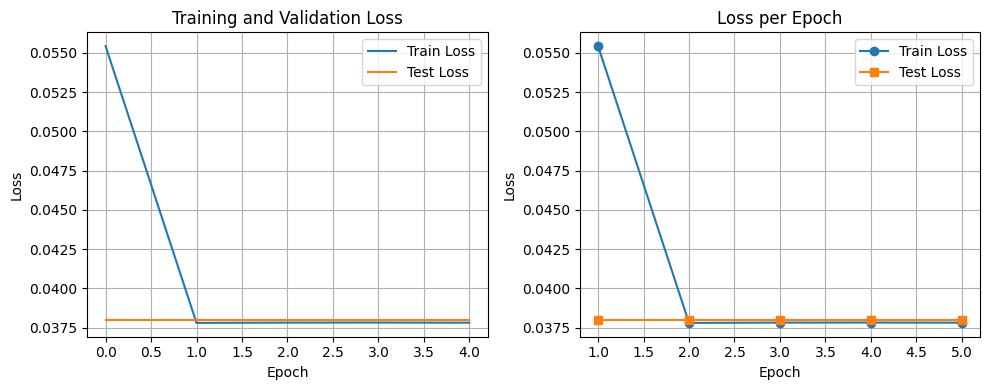


Testing model on multiple samples:
  Sample 0: output range [0.000000, 0.000000], mean: 0.000000
  Sample 1: output range [0.000000, 0.000000], mean: 0.000000
  Sample 2: output range [0.000000, 0.000000], mean: 0.000000


In [136]:
# Check model weights and training results
print("Model weight analysis:")
total_zero_weights = 0
total_weights = 0

for name, param in model_0.named_parameters():
    zero_weights = (param == 0).sum().item()
    total_param_weights = param.numel()
    total_zero_weights += zero_weights
    total_weights += total_param_weights
    
    if zero_weights > 0:
        percentage = zero_weights / total_param_weights * 100
        print(f"  {name}: {zero_weights}/{total_param_weights} zeros ({percentage:.2f}%)")

print(f"\nOverall: {total_zero_weights}/{total_weights} weights are zero ({total_zero_weights/total_weights*100:.2f}%)")

# Check training results
if 'model_0_results' in globals():
    print(f"\nTraining results:")
    print(f"  Final train loss: {model_0_results['train_loss'][-1]:.6f}")
    print(f"  Final test loss: {model_0_results['test_loss'][-1]:.6f}")
    
    # Plot training curves
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(model_0_results['train_loss'], label='Train Loss')
    plt.plot(model_0_results['test_loss'], label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    epochs = list(range(1, len(model_0_results['train_loss']) + 1))
    plt.plot(epochs, model_0_results['train_loss'], 'o-', label='Train Loss')
    plt.plot(epochs, model_0_results['test_loss'], 's-', label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
else:
    print("\nNo training results found - model may not have been trained yet!")

# Check a few sample model outputs for different inputs
print(f"\nTesting model on multiple samples:")
model_0.eval()
with torch.no_grad():
    for i in range(3):
        image, mask = test_dataset[i]
        output = model_0(image.unsqueeze(0).to(device))
        print(f"  Sample {i}: output range [{output.min().item():.6f}, {output.max().item():.6f}], mean: {output.mean().item():.6f}")

In [ ]:
# Debug model forward pass step by step
print("Debugging model forward pass:")

# Get a test input
test_image, _ = test_dataset[0]
test_input = test_image.unsqueeze(0).to(device)
print(f"Input shape: {test_input.shape}")
print(f"Input range: [{test_input.min().item():.4f}, {test_input.max().item():.4f}]")

model_0.eval()
with torch.no_grad():
    # Check encoder outputs
    e1 = model_0.encoder1(test_input)
    print(f"Encoder 1 output: {e1.shape}, range: [{e1.min().item():.4f}, {e1.max().item():.4f}]")
    
    p1 = nn.functional.max_pool2d(e1, 2, 2)
    print(f"Pool 1 output: {p1.shape}, range: [{p1.min().item():.4f}, {p1.max().item():.4f}]")
    
    e2 = model_0.encoder2(p1)
    print(f"Encoder 2 output: {e2.shape}, range: [{e2.min().item():.4f}, {e2.max().item():.4f}]")
    
    p2 = nn.functional.max_pool2d(e2, 2, 2)
    e3 = model_0.encoder3(p2)
    print(f"Encoder 3 output: {e3.shape}, range: [{e3.min().item():.4f}, {e3.max().item():.4f}]")
    
    p3 = nn.functional.max_pool2d(e3, 2, 2)
    e4 = model_0.encoder4(p3)
    print(f"Encoder 4 output: {e4.shape}, range: [{e4.min().item():.4f}, {e4.max().item():.4f}]")
    
    p4 = nn.functional.max_pool2d(e4, 2, 2)
    bottleneck = model_0.bottleneck(p4)
    print(f"Bottleneck output: {bottleneck.shape}, range: [{bottleneck.min().item():.4f}, {bottleneck.max().item():.4f}]")
    
    # Check decoder
    d4 = model_0.up4(bottleneck)
    print(f"Up4 output: {d4.shape}, range: [{d4.min().item():.4f}, {d4.max().item():.4f}]")
    
    d4_cat = torch.cat([d4, e4], dim=1)
    d4_final = model_0.decoder4(d4_cat)
    print(f"Decoder 4 output: {d4_final.shape}, range: [{d4_final.min().item():.4f}, {d4_final.max().item():.4f}]")
    
    # Continue with a few more steps
    d3 = model_0.up3(d4_final)
    d3_cat = torch.cat([d3, e3], dim=1)
    d3_final = model_0.decoder3(d3_cat)
    print(f"Decoder 3 output: {d3_final.shape}, range: [{d3_final.min().item():.4f}, {d3_final.max().item():.4f}]")
    
    # Check final layers
    d2 = model_0.up2(d3_final)
    d2_cat = torch.cat([d2, e2], dim=1)
    d2_final = model_0.decoder2(d2_cat)
    print(f"Decoder 2 output: {d2_final.shape}, range: [{d2_final.min().item():.4f}, {d2_final.max().item():.4f}]")
    
    d1 = model_0.up1(d2_final)
    d1_cat = torch.cat([d1, e1], dim=1)
    d1_final = model_0.decoder1(d1_cat)
    print(f"Decoder 1 output: {d1_final.shape}, range: [{d1_final.min().item():.4f}, {d1_final.max().item():.4f}]")
    
    # Final conv and sigmoid
    final_conv = model_0.final_conv(d1_final)
    print(f"Final conv output: {final_conv.shape}, range: [{final_conv.min().item():.4f}, {final_conv.max().item():.4f}]")
    
    final_output = model_0.sigmoid(final_conv)
    print(f"Final sigmoid output: {final_output.shape}, range: [{final_output.min().item():.4f}, {final_output.max().item():.4f}]")

# The issue might be that all the final conv weights are producing outputs near zero
# Let's check the final convolution layer weights
print(f"\nFinal convolution layer analysis:")
final_conv_layer = model_0.final_conv
print(f"Weight shape: {final_conv_layer.weight.shape}")
print(f"Weight range: [{final_conv_layer.weight.min().item():.6f}, {final_conv_layer.weight.max().item():.6f}]")
print(f"Weight mean: {final_conv_layer.weight.mean().item():.6f}")
print(f"Weight std: {final_conv_layer.weight.std().item():.6f}")
if final_conv_layer.bias is not None:
    print(f"Bias: {final_conv_layer.bias.item():.6f}")
else:
    print("No bias")

In [126]:
# Hyperparameter tuning with Optuna
def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    base_channels = trial.suggest_categorical('base_channels', [16, 32, 64])
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW', 'SGD'])
    loss_function = trial.suggest_categorical('loss', ['MSE', 'BCE', 'Dice'])
    
    # Create model with suggested parameters
    model = LightVGG16_UNet(base_channels=base_channels).to(device)
    
    # Create optimizer
    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'AdamW':
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    else:  # SGD
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    
    # Create loss function
    if loss_function == 'MSE':
        criterion = nn.MSELoss()
    elif loss_function == 'BCE':
        criterion = nn.BCELoss()
    else:  # Dice
        criterion = DiceLoss()
    
    # Create data loaders with suggested batch size
    train_loader_hp = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=0,
        pin_memory=True,
        drop_last=True
    )
    
    test_loader_hp = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0,
        pin_memory=True
    )
    
    # Quick training for 3 epochs to evaluate hyperparameters
    best_val_loss = float('inf')
    
    for epoch in range(3):  # Reduced epochs for faster tuning
        # Training
        model.train()
        train_loss = 0
        for images, masks in train_loader_hp:
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in test_loader_hp:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()
        
        val_loss /= len(test_loader_hp)
        
        # Report intermediate objective value
        trial.report(val_loss, epoch)
        
        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
    
    return best_val_loss

In [127]:
# Run hyperparameter optimization
def run_hyperparameter_tuning(n_trials=20):
    # Create a study object
    study = optuna.create_study(
        direction='minimize',
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)
    )
    
    print(f"Starting hyperparameter optimization with {n_trials} trials...")
    print("This may take a while depending on your hardware.")
    
    # Optimize the objective function
    study.optimize(objective, n_trials=n_trials, timeout=3600)  # 1 hour timeout
    
    # Print results
    print("Study statistics: ")
    print(f"  Number of finished trials: {len(study.trials)}")
    print(f"  Number of pruned trials: {len(study.get_trials(deepcopy=False, states=[TrialState.PRUNED]))}")
    print(f"  Number of complete trials: {len(study.get_trials(deepcopy=False, states=[TrialState.COMPLETE]))}")
    
    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")
    
    return study

# Function to create optimized model with best parameters
def create_optimized_model(best_params):
    model = LightVGG16_UNet(base_channels=best_params['base_channels']).to(device)
    
    if best_params['optimizer'] == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
    elif best_params['optimizer'] == 'AdamW':
        optimizer = torch.optim.AdamW(model.parameters(), lr=best_params['lr'], weight_decay=1e-4)
    else:  # SGD
        optimizer = torch.optim.SGD(model.parameters(), lr=best_params['lr'], momentum=0.9)
    
    if best_params['loss'] == 'MSE':
        criterion = nn.MSELoss()
    elif best_params['loss'] == 'BCE':
        criterion = nn.BCELoss()
    else:  # Dice
        criterion = DiceLoss()
    
    # Create optimized data loaders
    train_loader_opt = DataLoader(
        train_dataset, 
        batch_size=best_params['batch_size'], 
        shuffle=True, 
        num_workers=0,
        pin_memory=True,
        drop_last=True
    )
    
    test_loader_opt = DataLoader(
        test_dataset, 
        batch_size=best_params['batch_size'], 
        shuffle=False, 
        num_workers=0,
        pin_memory=True
    )
    
    return model, optimizer, criterion, train_loader_opt, test_loader_opt

# Compare model sizes
def compare_model_sizes():
    # Original VGG-UNet
    original_model = VGG16_UNet().to(device)
    original_params = sum(p.numel() for p in original_model.parameters())
    
    # Lightweight versions
    light_16 = LightVGG16_UNet(base_channels=16).to(device)
    light_32 = LightVGG16_UNet(base_channels=32).to(device)
    light_64 = LightVGG16_UNet(base_channels=64).to(device)
    
    light_16_params = sum(p.numel() for p in light_16.parameters())
    light_32_params = sum(p.numel() for p in light_32.parameters())
    light_64_params = sum(p.numel() for p in light_64.parameters())
    
    def format_params(n):
        if n >= 1e6:
            return f"{n/1e6:.2f}M"
        elif n >= 1e3:
            return f"{n/1e3:.2f}K"
        return str(n)
    
    print("Model Size Comparison:")
    print(f"Original VGG-UNet:     {format_params(original_params)} ({original_params:,})")
    print(f"Light VGG-UNet (16):   {format_params(light_16_params)} ({light_16_params:,}) - {light_16_params/original_params*100:.1f}% of original")
    print(f"Light VGG-UNet (32):   {format_params(light_32_params)} ({light_32_params:,}) - {light_32_params/original_params*100:.1f}% of original")
    print(f"Light VGG-UNet (64):   {format_params(light_64_params)} ({light_64_params:,}) - {light_64_params/original_params*100:.1f}% of original")

# Show model comparison
compare_model_sizes()

Model Size Comparison:
Original VGG-UNet:     20.29M (20,294,465)
Light VGG-UNet (16):   1.94M (1,941,105) - 9.6% of original
Light VGG-UNet (32):   7.76M (7,760,097) - 38.2% of original
Light VGG-UNet (64):   31.03M (31,031,745) - 152.9% of original


In [ ]:
# Example usage - Uncomment to run hyperparameter tuning
"""
# Run hyperparameter optimization (this will take time)
study = run_hyperparameter_tuning(n_trials=10)  # Start with fewer trials

# Get best parameters
best_params = study.best_params
print(f"Best parameters: {best_params}")

# Create optimized model
opt_model, opt_optimizer, opt_criterion, opt_train_loader, opt_test_loader = create_optimized_model(best_params)

# Train the optimized model
opt_results = train(
    model=opt_model,
    train_loader=opt_train_loader,
    test_loader=opt_test_loader,
    optimizer=opt_optimizer,
    loss=opt_criterion,
    device=device,
    epochs=10
)
"""

# Mac NPU Optimization Tips
print("Mac NPU Optimization Tips:")
print("=" * 40)
print("1. Use MPS device (Metal Performance Shaders)")
print(f"   Current device: {device}")
print("\n2. Optimize batch sizes for memory efficiency")
print("   - Start with smaller batches (8-16)")
print("   - Monitor memory usage")
print("\n3. Use mixed precision training (if supported)")
print("   - Can reduce memory usage by ~50%")
print("   - May provide speed improvements")
print("\n4. Model optimizations:")
print("   - Use lightweight architectures")
print("   - Reduce channel dimensions")
print("   - Use depthwise separable convolutions")
print("\n5. Data loading optimizations:")
print("   - Set num_workers=0 for Mac")
print("   - Use pin_memory=True")
print("   - Consider smaller image sizes")

# Check MPS availability and properties
if torch.backends.mps.is_available():
    print(f"\n✅ MPS is available!")
    print("To maximize performance:")
    print("- Use torch.mps.synchronize() for accurate timing")
    print("- Monitor memory with torch.mps.current_allocated_memory()")
else:
    print(f"\n❌ MPS not available, using CPU")

# Memory usage function for Mac
def check_memory_usage():
    if device == 'mps':
        allocated = torch.mps.current_allocated_memory()
        print(f"MPS Memory allocated: {allocated / 1024**3:.2f} GB")
    else:
        print("Memory monitoring only available for MPS device")

check_memory_usage()